In [1]:
import numpy as np
import os,sys


sys.path.append('../../../RL_lib/Agents')
sys.path.append('../../../RL_lib/Policies/PPO')
sys.path.append('../../../RL_lib/Policies/Common')
sys.path.append('../../../RL_lib/Utils')
sys.path.append('../../Env')
sys.path.append('../../Imaging')
%load_ext autoreload
%load_ext autoreload
%autoreload 2
%matplotlib nbagg
import os
print(os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/briangaudet/Study/Subjects/MachineLearning/Projects/RL_repo/Exo_intercept/Experiments/EKV/Test_PN


In [2]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:1000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

# Optimize Policy

Quaternion_attitude
Euler321 Attitude
C_cb: 
[[ 6.123234e-17  0.000000e+00 -1.000000e+00]
 [ 0.000000e+00  1.000000e+00  0.000000e+00]
 [ 1.000000e+00  0.000000e+00  6.123234e-17]]
[1.000000e+00 0.000000e+00 6.123234e-17]
using max  pooling
Angle sensor:
	Output State type:  <function Angle_sensor.optflow_state at 0x154df3d90>
	Offset Init type:  <function Angle_sensor.offset_init1 at 0x154df39d8>
	Fixed Offset:  None
3dof dynamics model
3-dof Actuator Model:  49.050000000000004
Inertia Tensor:  [[333.33333333   0.           0.        ]
 [  0.         333.33333333   0.        ]
 [  0.           0.         333.33333333]]
Target Model: 
 - foo:  0.0
6dof dynamics model
thruster model:  [4905. 4905. 4905. 4905.]
Rotational Velocity Constraint
Attitude Constraint
Inertia Tensor:  [[1.04166667 0.         0.        ]
 [0.         7.29166667 0.        ]
 [0.         0.         7.29166667]]
Missile Model: 
 - foo:  0.0
Reward_terminal


<IPython.core.display.Javascript object>


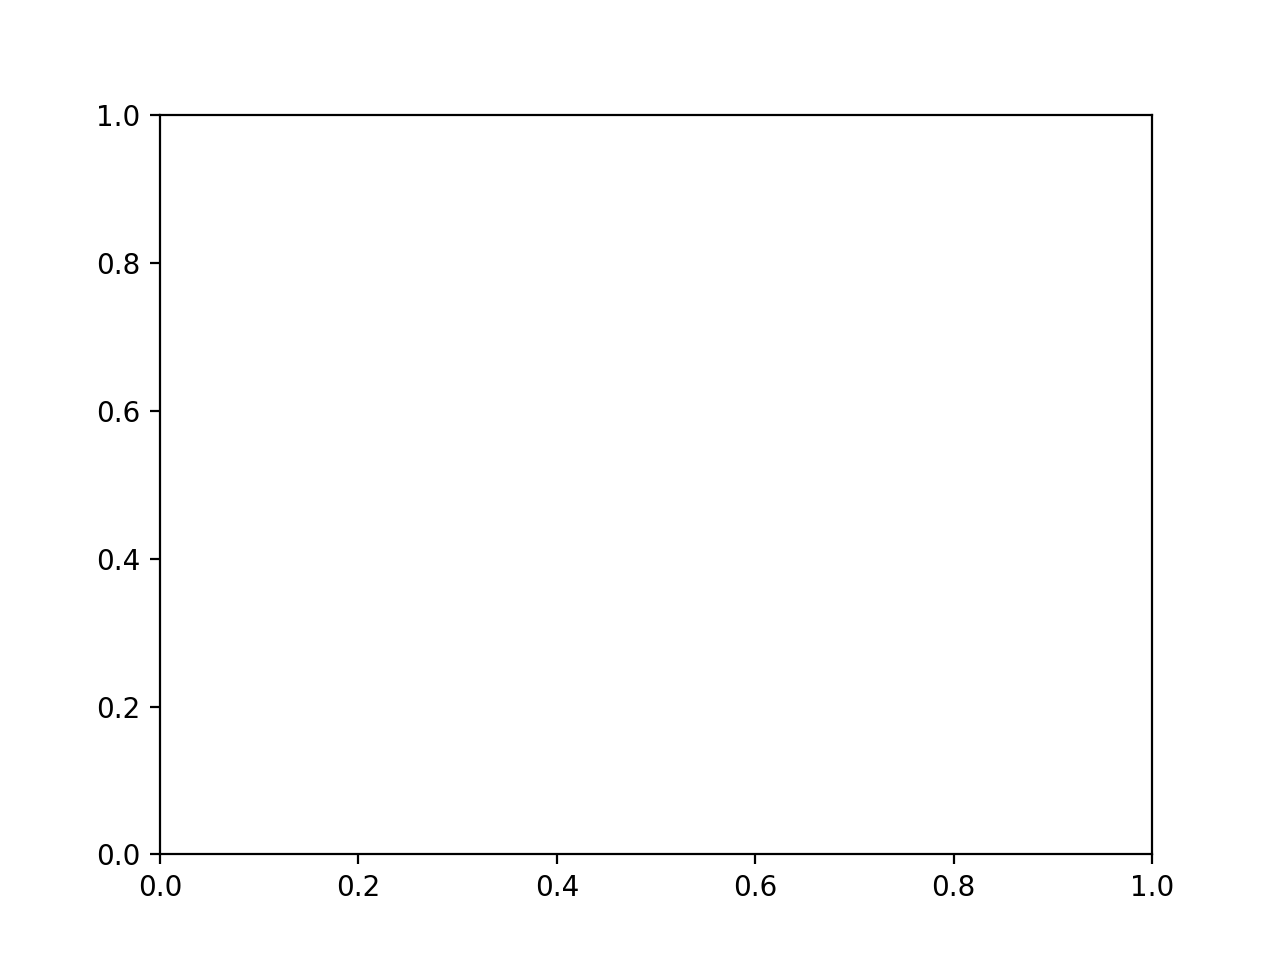

<IPython.core.display.Javascript object>


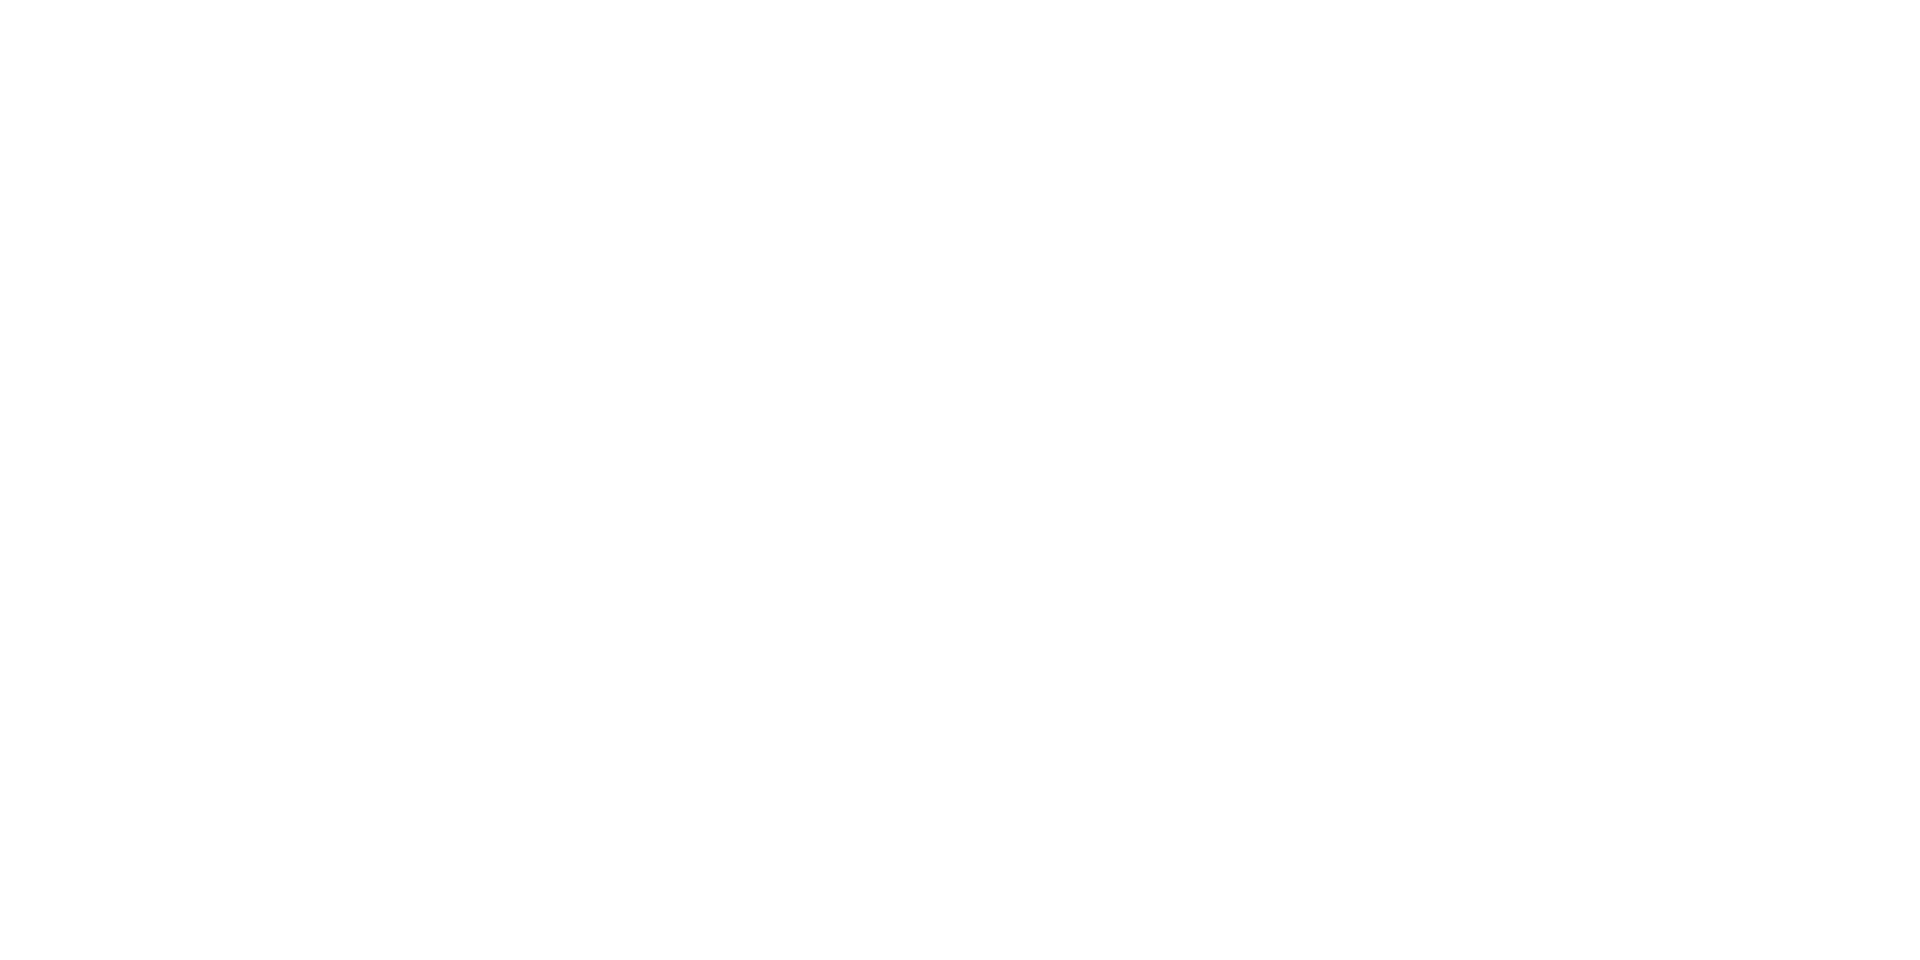

<IPython.core.display.Javascript object>


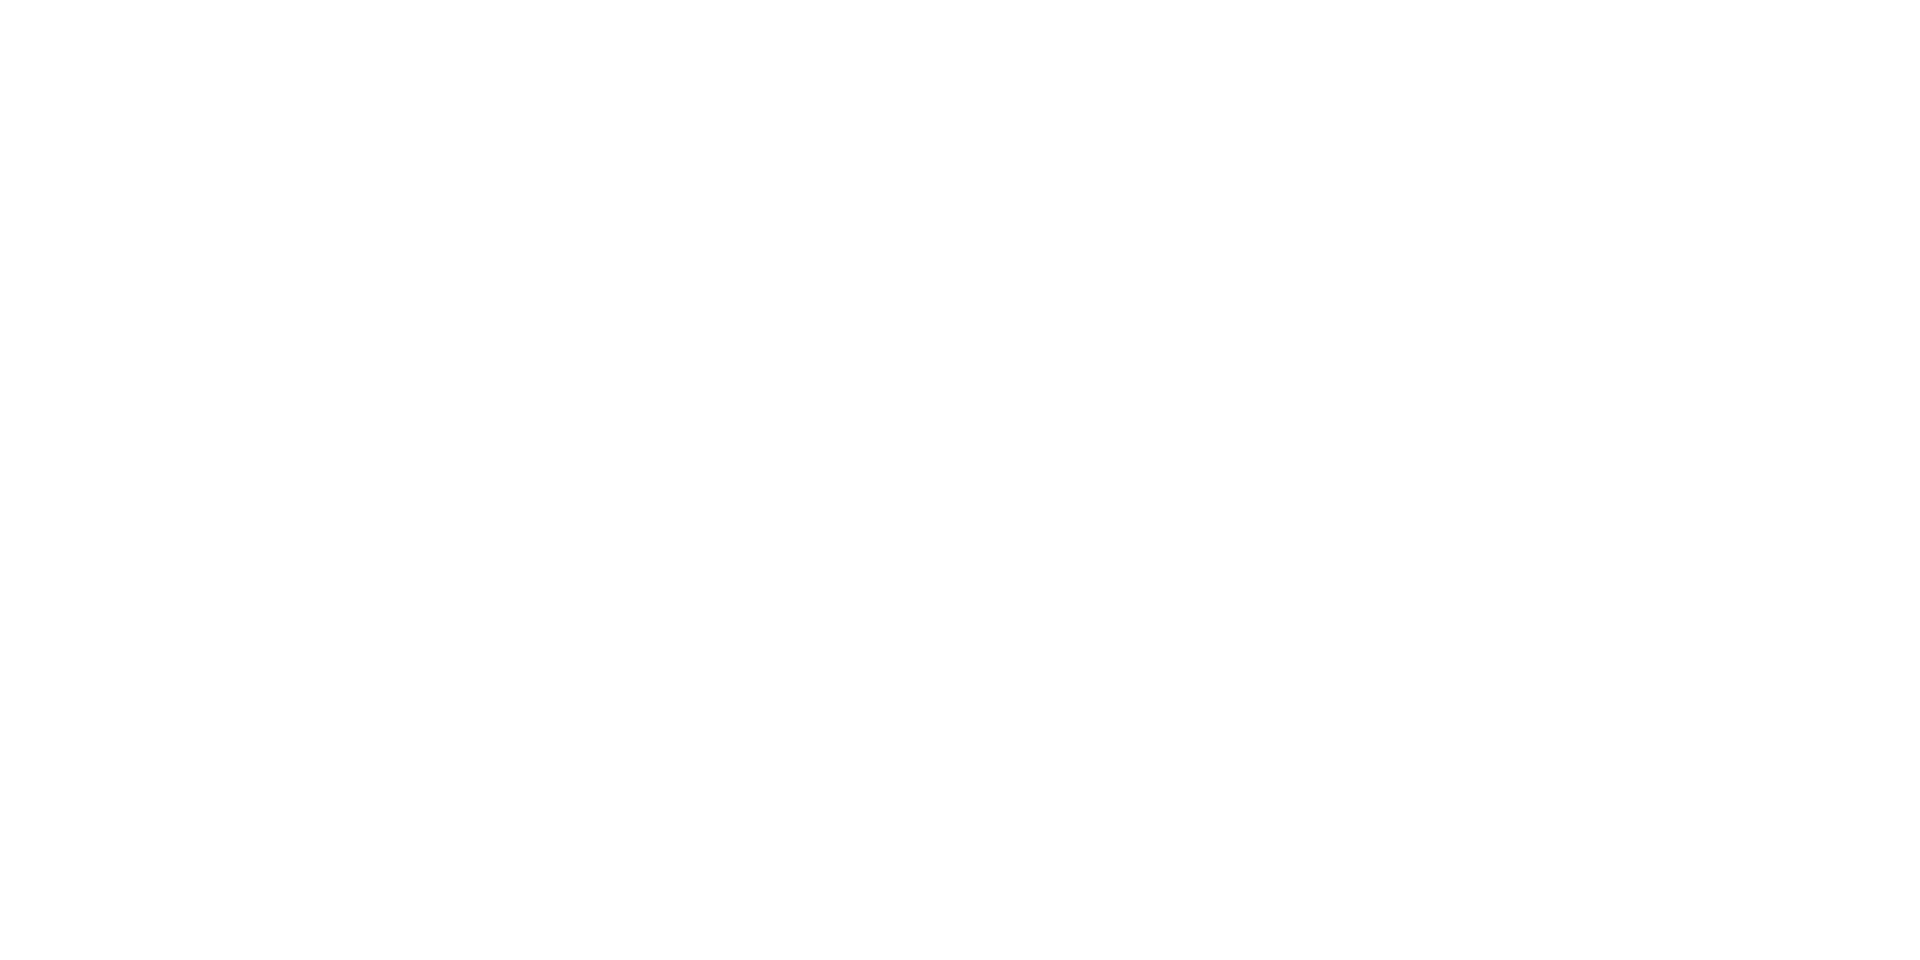

<IPython.core.display.Javascript object>


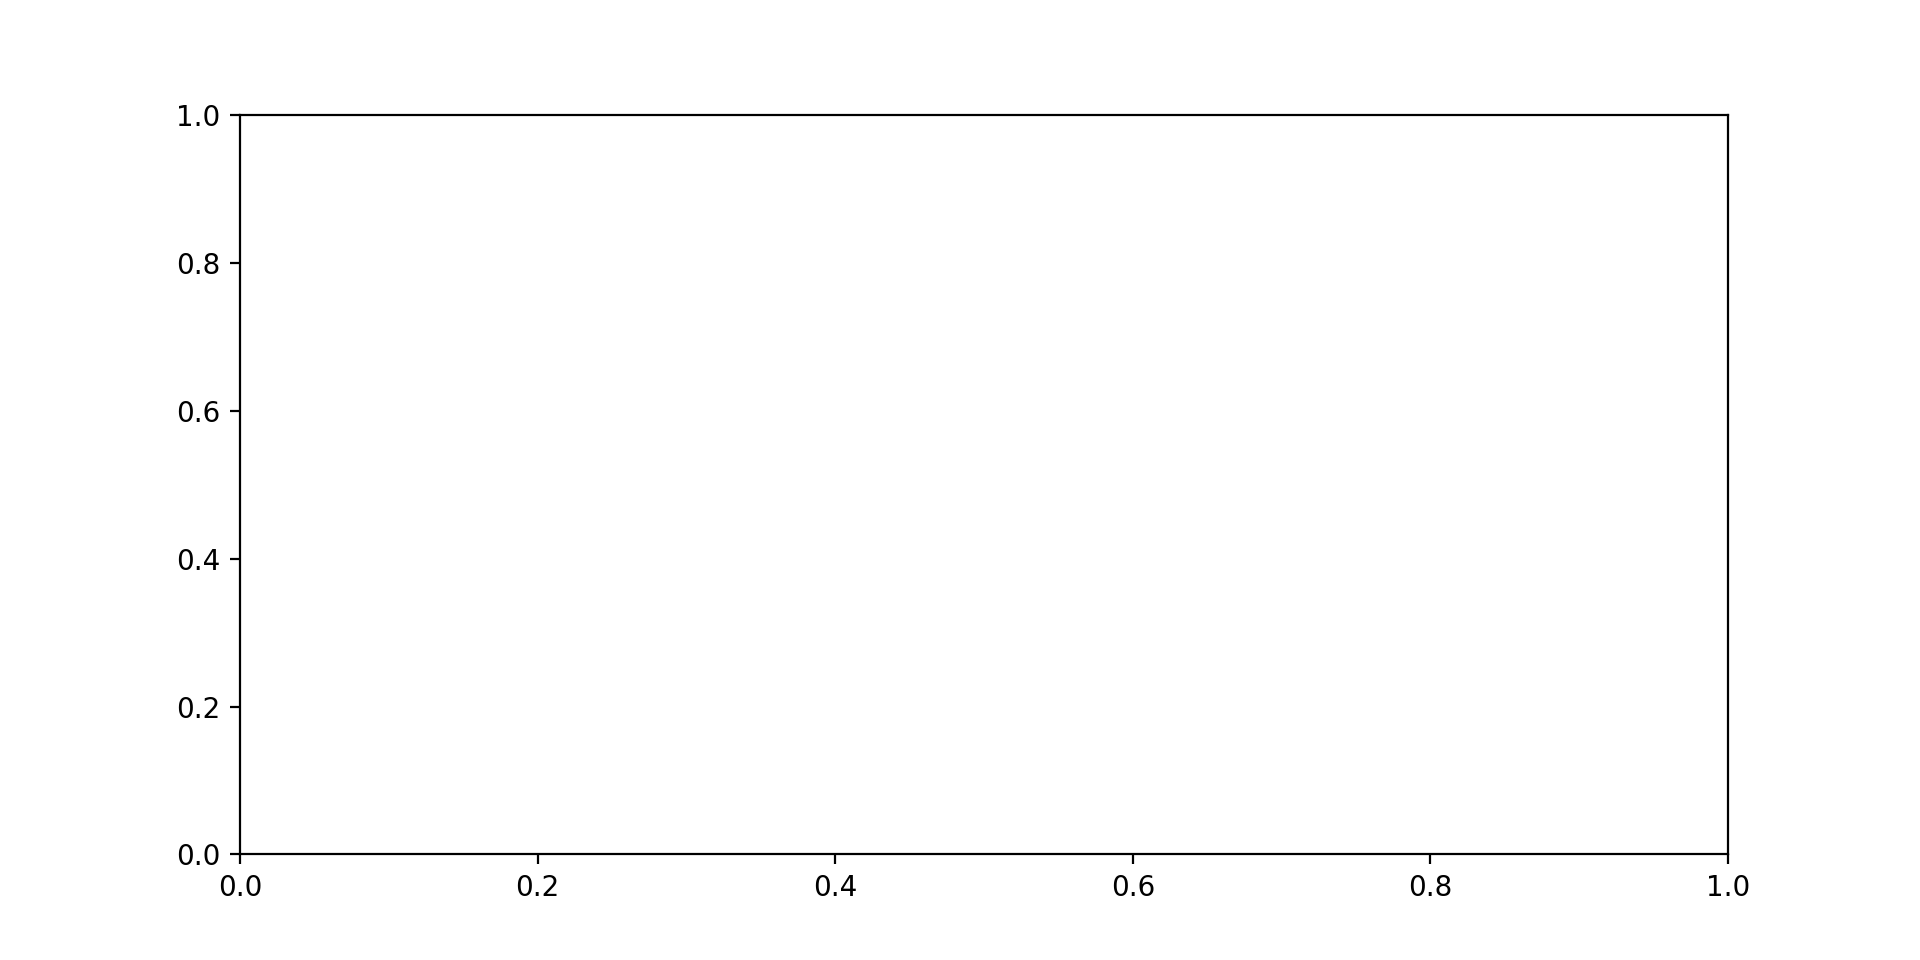

Missile env fixed (h= 0.02
Value Funtion
	xn_init: layer  Linear(in_features=19, out_features=190, bias=True)
	xn_init: layer  GRUCell(190, 30)
	xn_init: layer  Linear(in_features=30, out_features=5, bias=True)
	xn_init: layer  Linear(in_features=5, out_features=1, bias=True)
Value Function: recurrent steps > 1, disabling shuffle and batching
	Clip Range:         0.5
	Shuffle :           False
	Batch Size :        9999999
	Max Grad Norm:      30
	Recurrent Steps:    200
	Rollout Limit:      1
Agent


In [8]:
from env import Env
import env_utils as envu
from reward_sensor_gaussian_of import Reward

import attitude_utils as attu

from missile import Missile
from target import Target

from missile_icgen import Missile_icgen
from target_icgen import Target_icgen

from dynamics_model_3dof import Dynamics_model_3dof as Target_dynamics_model
from dynamics_model_6dof import Dynamics_model_6dof as Missile_dynamics_model

from bangbang_policy_ra import BangBang_policy as Target_policy

from no_att_constraint import No_att_constraint
from no_w_constraint import No_w_constraint

######### RL vs PN ###########

is_RL = False

########## RL ###########

import rl_utils
from arch_policy_vf import Arch
import policy_nets as policy_nets
import valfunc_nets as vf_nets
from agent import Agent
from value_function import Value_function

if is_RL:
    from policy import Policy
    from softmax_pd import Softmax_pd as PD
else:
    from zem_policy import ZEM_policy as Policy
    
######### Actuator Models #########

from actuator_model_ekv import Actuator_model_ekv as Missile_actuator_model 
from actuator_model_3dof import Actuator_model_3dof as Target_actuator_model

######## Sensor ##############

from angle_sensor import Angle_sensor
from eo_model import EO_model
import optics_utils as optu

ap = attu.Quaternion_attitude()

offset=np.asarray([0,0])
C_cb = optu.rotate_optical_axis(0.0, np.pi/2, 0.0)
r_cb = np.asarray([0,0,0])
fov=np.pi-np.pi/8
cm = EO_model(attitude_parameterization=ap, C_cb=C_cb, r_cb=r_cb, 
                   fov=fov, debug=False, p_x=96,p_y=96)
sensor = Angle_sensor(cm, attitude_parameterization=ap,  use_range=True, ignore_fov_vio=not is_RL,
                      use_ideal_offset=False,
                      pool_type='max', state_type=Angle_sensor.optflow_state, optflow_scale=0.1)


########## Target ############

target_voffset = 10
target_max_acc = 5*9.81
target_max_acc_range = (0., target_max_acc)
target_dynamics_model = Target_dynamics_model(h=0.02,M=1e3)
target_actuator_model = Target_actuator_model(max_acc=target_max_acc)
target_policy = Target_policy(3,max_acc_range=target_max_acc_range,tf=80)
target = Target(target_policy, target_actuator_model, target_dynamics_model, attitude_parameterization=ap)

target_icgen = Target_icgen(attitude_parameterization=ap,
                            min_init_position=(0.0, 0.0, 50000.),
                            max_init_position=(0.0, 0.0, 50000.),
                            v_mag=(4000., 4000.),
                            v_theta=(envu.deg2rad(90-target_voffset), envu.deg2rad(90+target_voffset)),
                            v_phi=(envu.deg2rad(-target_voffset), envu.deg2rad(target_voffset)))

########## Missile  #############

missile_roffset = 10
missile_mass = 50
missile_max_thrust =  10*9.81*missile_mass

missile_dynamics_model = Missile_dynamics_model(h=0.02,M=1e3)

missile_actuator_model = Missile_actuator_model(max_thrust=missile_max_thrust,pulsed=True)
missile = Missile(target, missile_actuator_model, missile_dynamics_model, sensor=sensor, 
                  attitude_parameterization=ap,
                  w_constraint=No_w_constraint(), att_constraint=No_att_constraint(ap),
                 align_cv=False, debug_cv=False, perturb_pn_velocity=True)
if not is_RL:
    missile.get_state_agent = missile.get_state_agent_PN_att
    
missile_icgen = Missile_icgen(attitude_parameterization=ap,
                           position_r=(50000.,55000.),
                           position_theta=(envu.deg2rad(90-missile_roffset),envu.deg2rad(90+missile_roffset)),
                           position_phi=(envu.deg2rad(-missile_roffset),envu.deg2rad(missile_roffset)),
                           mag_v=(3000,3000),
                           heading_error=(envu.deg2rad(0),envu.deg2rad(5)),
                           attitude_error=(0.0,0.0),
                           debug=False)


reward_object = Reward(debug=False, hit_coeff=10., tracking_coeff=1., tracking_sigma=0.10, optflow_sigma=0.004, 
                       fuel_coeff=0.0, fov_coeff=-0., hit_rlimit=0.5)

logger = rl_utils.Logger()

env = Env(missile, target, missile_icgen, target_icgen,  logger, 
          precision_range=1000., precision_scale=300, terminate_on_vc=not is_RL,
          reward_object=reward_object, use_offset=False, debug_steps=True,
          tf_limit=50.0,print_every=10,nav_period=0.10)

                

##########################################
recurrent_steps = 200
if is_RL:
    obs_dim = 4
    action_dim = 4
    actions_per_dim = 2
    logit_dim = action_dim * actions_per_dim
    policy = Policy(policy_nets.GRU1(obs_dim, logit_dim, recurrent_steps=recurrent_steps), 
                PD(action_dim, actions_per_dim),
                shuffle=False,
                kl_targ=0.001,epochs=20, beta=0.1, servo_kl=True, max_grad_norm=30, scale_vector_obs=True,
                init_func=rl_utils.xn_init)
else:
    policy = Policy(ap=ap, N=3, max_acc=missile_max_thrust / missile_mass)
    obs_dim = 19
    act_dim = 4
    
arch = Arch()

value_function = Value_function(vf_nets.GRU1(obs_dim, recurrent_steps=recurrent_steps), scale_obs=True,
                                shuffle=False, batch_size=9999999, max_grad_norm=30, 
                                verbose=False)

agent = Agent(arch, policy, value_function, None, env, logger,
              policy_episodes=30, policy_steps=3000, gamma1=0.90, gamma2=0.995, 
              recurrent_steps=recurrent_steps, monitor=env.rl_stats)

if is_RL:
    agent.train(300000)

# Test Policy 


In [9]:

env.test_policy_batch(agent,5000,print_every=100,test_mode=True)

worked 1
Dynamics: Max Disturbance (m/s^2):  [1.24093419e-12 8.71438479e-14 1.25393720e-12] 1.766315431544111e-12
Dynamics: Max Disturbance (m/s^2):  [0.0000e+00 0.0000e+00 2.6696e-12] 2.6695999999999994e-12
i (et): 100  (             211)
Cumulative Stats (mean,std,max,argmax)
thrust   |2361.21 |2726.28 |  0.00 |6936.72 |    19
 
Final Stats (mean,std,min,max)
hit_reward |     4.4 |     5.0 |     0.0 |    10.0
hit_100cm |    0.96 |    0.20 |    0.00 |    1.00
hit_50cm |    0.44 |    0.50 |    0.00 |    1.00
norm_vf  |6832.468 | 174.564 |5980.703 |7008.324
norm_rf  |     0.6 |     0.2 |     0.0 |     1.1
position | 30562.5   398.1 49983.1 |   996.5  3330.5  3148.6 | 28537.5 -5877.5 44599.9 | 34739.4  5506.7 55633.1
velocity |-2815.466  60.210-143.855 | 183.902 714.005 738.823 |-3008.636-1723.649-1709.373 |-1917.9591464.8171585.723
fuel     |  9.91 |  3.33 |  2.15 | 16.66
attitude_321 |   0.439   0.044   0.189 |   2.897   0.260   1.698 |  -3.134  -0.582  -3.081 |   3.135   0.589   2.952

Dynamics: Max Disturbance (m/s^2):  [1.58705693e-12 2.69007240e-13 2.12193042e-12] 2.6634006980227994e-12
Dynamics: Max Disturbance (m/s^2):  [1.45841830e-12 2.38470485e-13 2.68996417e-12] 3.069162644122132e-12
i (et): 900  (             227)
Cumulative Stats (mean,std,max,argmax)
thrust   |2386.07 |2730.00 |  0.00 |6936.72 |    19
 
Final Stats (mean,std,min,max)
hit_reward |     4.6 |     5.0 |     0.0 |    10.0
hit_100cm |    0.97 |    0.17 |    0.00 |    1.00
hit_50cm |    0.46 |    0.50 |    0.00 |    1.00
norm_vf  |6820.704 | 156.779 |5980.703 |7021.903
norm_rf  |     0.5 |     0.2 |     0.0 |     2.4
position | 30536.2   243.5 50076.6 |  1065.6  3109.2  3133.9 | 28007.2 -5877.5 44133.6 | 34739.4  5674.0 55657.9
velocity |-2794.020  34.765   2.239 | 167.712 773.142 784.224 |-3021.224-1723.649-1712.221 |-1917.9591788.9991719.498
fuel     | 10.00 |  3.48 |  1.06 | 20.17
attitude_321 |   0.074  -0.002  -0.059 |   2.914   0.270   1.789 |  -3.142  -0.638  -3.131 |   3.141   0.634   3.

Dynamics: Max Disturbance (m/s^2):  [1.58705693e-12 2.69007240e-13 2.12193042e-12] 2.6634006980227994e-12
Dynamics: Max Disturbance (m/s^2):  [1.45841830e-12 2.38691183e-13 2.69012760e-12] 3.069323040863224e-12
i (et): 1700  (             229)
Cumulative Stats (mean,std,max,argmax)
thrust   |2404.65 |2734.08 |  0.00 |6936.72 |    19
 
Final Stats (mean,std,min,max)
hit_reward |     4.6 |     5.0 |     0.0 |    10.0
hit_100cm |    0.97 |    0.16 |    0.00 |    1.00
hit_50cm |    0.46 |    0.50 |    0.00 |    1.00
norm_vf  |6817.821 | 157.691 |5980.703 |7021.903
norm_rf  |     0.5 |     0.2 |     0.0 |     3.1
position | 30548.8   150.8 50043.3 |  1074.6  3094.5  3138.9 | 28007.2 -5877.5 44133.6 | 34739.4  5867.7 55852.1
velocity |-2790.943  22.520 -27.651 | 169.973 783.178 784.909 |-3021.224-1723.649-1782.415 |-1917.9591788.9991849.660
fuel     | 10.09 |  3.51 |  1.06 | 22.09
attitude_321 |   0.034   0.009   0.038 |   2.911   0.269   1.773 |  -3.142  -0.676  -3.131 |   3.141   0.656   3

Dynamics: Max Disturbance (m/s^2):  [1.58705693e-12 2.69007240e-13 2.12193042e-12] 2.6634006980227994e-12
Dynamics: Max Disturbance (m/s^2):  [1.45841830e-12 2.42848556e-13 2.69012760e-12] 3.069649144339414e-12
i (et): 2500  (             238)
Cumulative Stats (mean,std,max,argmax)
thrust   |2394.61 |2734.27 |  0.00 |6936.72 |    19
 
Final Stats (mean,std,min,max)
hit_reward |     4.6 |     5.0 |     0.0 |    10.0
hit_100cm |    0.97 |    0.17 |    0.00 |    1.00
hit_50cm |    0.46 |    0.50 |    0.00 |    1.00
norm_vf  |6818.103 | 158.550 |5980.703 |7021.903
norm_rf  |     0.5 |     0.3 |     0.0 |     6.3
position | 30544.9   121.8 50059.7 |  1084.1  3101.2  3119.3 | 28007.2 -5877.5 44133.6 | 34739.4  5901.3 55852.1
velocity |-2790.307  25.073 -10.620 | 172.262 787.214 782.567 |-3021.224-1723.649-1782.415 |-1917.9591788.9991849.660
fuel     | 10.05 |  3.55 |  1.06 | 22.09
attitude_321 |   0.012   0.004   0.021 |   2.911   0.269   1.768 |  -3.142  -0.676  -3.131 |   3.141   0.656   3

Dynamics: Max Disturbance (m/s^2):  [1.58827595e-12 2.69007240e-13 2.12193042e-12] 2.6641272666329998e-12
Dynamics: Max Disturbance (m/s^2):  [1.45841830e-12 2.42848556e-13 2.69012760e-12] 3.069649144339414e-12
i (et): 3300  (             233)
Cumulative Stats (mean,std,max,argmax)
thrust   |2401.52 |2735.45 |  0.00 |6936.72 |    19
 
Final Stats (mean,std,min,max)
hit_reward |     4.7 |     5.0 |     0.0 |    10.0
hit_100cm |    0.97 |    0.17 |    0.00 |    1.00
hit_50cm |    0.47 |    0.50 |    0.00 |    1.00
norm_vf  |6817.897 | 159.545 |5980.703 |7021.903
norm_rf  |     0.5 |     0.3 |     0.0 |     6.3
position | 30529.9   102.4 50019.2 |  1088.6  3114.4  3126.3 | 28007.2 -5877.5 44133.6 | 34739.4  5901.3 55852.1
velocity |-2790.044  21.521  -3.513 | 172.914 785.376 785.759 |-3021.224-1755.242-1782.415 |-1917.9591788.9991849.660
fuel     | 10.08 |  3.54 |  1.06 | 22.09
attitude_321 |   0.014   0.002   0.012 |   2.911   0.270   1.765 |  -3.142  -0.676  -3.131 |   3.141   0.656   3

i (et): 4100  (             220)
Cumulative Stats (mean,std,max,argmax)
thrust   |2399.59 |2735.86 |  0.00 |6936.72 |    19
 
Final Stats (mean,std,min,max)
hit_reward |     4.7 |     5.0 |     0.0 |    10.0
hit_100cm |    0.97 |    0.17 |    0.00 |    1.00
hit_50cm |    0.47 |    0.50 |    0.00 |    1.00
norm_vf  |6819.147 | 157.970 |5980.703 |7021.903
norm_rf  |     0.5 |     0.3 |     0.0 |     6.3
position | 30516.0    87.6 49998.4 |  1089.2  3117.6  3119.8 | 28007.2 -5989.0 44133.6 | 34739.4  5901.3 55852.1
velocity |-2791.139  17.722  -5.755 | 171.534 783.684 783.811 |-3021.224-1755.242-1782.415 |-1917.9591788.9991849.660
fuel     | 10.07 |  3.54 |  1.06 | 22.09
attitude_321 |   0.025   0.002   0.019 |   2.911   0.270   1.762 |  -3.142  -0.676  -3.141 |   3.141   0.656   3.141
w        |   0.000   0.000   0.000 |   0.000   0.000   0.000 |   0.000   0.000   0.000 |   0.000   0.000   0.000
Dynamics: Max Disturbance (m/s^2):  [1.58827595e-12 2.69007240e-13 2.12193042e-12] 2.66412726

i (et): 4900  (             232)
Cumulative Stats (mean,std,max,argmax)
thrust   |2390.86 |2735.31 |  0.00 |6936.72 |    19
 
Final Stats (mean,std,min,max)
hit_reward |     4.7 |     5.0 |     0.0 |    10.0
hit_100cm |    0.97 |    0.16 |    0.00 |    1.00
hit_50cm |    0.47 |    0.50 |    0.00 |    1.00
norm_vf  |6817.783 | 159.126 |5951.442 |7021.903
norm_rf  |     0.5 |     0.3 |     0.0 |     6.3
position | 30519.9    53.5 50025.4 |  1096.1  3116.4  3125.4 | 28007.2 -5989.0 44133.6 | 35241.9  5901.3 56400.7
velocity |-2789.705  12.530  -4.500 | 172.839 787.629 784.588 |-3021.224-1755.242-1782.415 |-1869.6621788.9991849.660
fuel     | 10.03 |  3.56 |  1.06 | 22.09
attitude_321 |   0.022   0.002   0.018 |   2.910   0.269   1.765 |  -3.142  -0.676  -3.141 |   3.141   0.656   3.141
w        |   0.000   0.000   0.000 |   0.000   0.000   0.000 |   0.000   0.000   0.000 |   0.000   0.000   0.000
Dynamics: Max Disturbance (m/s^2):  [1.58827595e-12 2.74309631e-13 2.12193042e-12] 2.66466789